In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import duckdb

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import lightgbm as lgb

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Load data

In [7]:
df = pd.read_csv("ds_salaries.csv")

In [8]:
df.sample(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1560,2023,SE,FT,Research Scientist,210000,USD,210000,US,0,US,M
2780,2022,SE,FT,Data Engineer,141300,USD,141300,US,0,US,M
3503,2021,EN,FT,Machine Learning Developer,100000,USD,100000,IQ,50,IQ,S
2490,2022,SE,FT,Data Engineer,236000,USD,236000,US,100,US,M
3665,2021,MI,FT,Data Scientist,76760,EUR,90734,DE,50,DE,L


In [9]:
df.shape

(3755, 11)

# 2. Check data quality

data type

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


unique value

In [11]:
df.shape

(3755, 11)

In [12]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  work_year
Unique value:  [2023 2022 2020 2021]
Count unique value:  4
----------
Columns name:  experience_level
Unique value:  ['SE' 'MI' 'EN' 'EX']
Count unique value:  4
----------
Columns name:  employment_type
Unique value:  ['FT' 'CT' 'FL' 'PT']
Count unique value:  4
----------
Columns name:  job_title
Unique value:  ['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Da

In [13]:
duckdb.query("""
select max(work_year), min(work_year)
from df
""").to_df()

,max(work_year),min(work_year)
0,2023,2020


missing value

In [14]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

# 3. Feature engineering

In [15]:
duckdb.query("""
select * from df
""").to_df()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


work tenure

In [16]:
df = duckdb.query("""
select *
, work_year-work_year as tenure
from df
""").to_df()

In [17]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,tenure
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,0
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,0


experience level

In [18]:
df = duckdb.query("""
select *
, case when experience_level = 'EN' then 1 else 0 end exp_entry
, case when experience_level = 'MI' then 1 else 0 end exp_mid
, case when experience_level = 'SE' then 1 else 0 end exp_senior
, case when experience_level = 'EX' then 1 else 0 end exp_expert
from df
""").to_df()

In [19]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,tenure,exp_entry,exp_mid,exp_senior,exp_expert
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,0,0,0,1,0
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,0,0,1,0,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,0,0,1,0,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,0,0,0,1,0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,0,0,0,1,0


employment level

In [20]:
df = duckdb.query("""
select *
, case when employment_type = 'PT' then 1 else 0 end emptype_parttime
, case when employment_type = 'FL' then 1 else 0 end emptype_freelance
, case when employment_type = 'CT' then 1 else 0 end emptype_contract
, case when employment_type = 'FT' then 1 else 0 end emptype_fulltime
from df
""").to_df()

In [21]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,tenure,exp_entry,exp_mid,exp_senior,exp_expert,emptype_parttime,emptype_freelance,emptype_contract,emptype_fulltime
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,0,0,0,1,0,0,0,0,1
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,0,0,1,0,0,0,0,1,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,0,0,1,0,0,0,0,1,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,0,0,0,1,0,0,0,0,1
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,0,0,0,1,0,0,0,0,1


job title

In [22]:
df = duckdb.query("""
select *
, case when job_title ilike '%scien%' then 1 else 0 end title_ds
, case when job_title ilike '%learning%' then 1 else 0 end title_mle
, case when (job_title ilike '%analys%') or (job_title like '%BI%') then 1 else 0 end title_da
, case when job_title ilike '%data engineer%' then 1 else 0 end title_de
, case when (job_title ilike '%research%') or (employment_type like '%computer vision%') then 1 else 0 end title_research
from df
""").to_df()

In [23]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,exp_expert,emptype_parttime,emptype_freelance,emptype_contract,emptype_fulltime,title_ds,title_mle,title_da,title_de,title_research
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,...,0,0,0,0,1,1,0,0,0,0
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,...,0,0,0,1,0,0,0,0,0,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,...,0,0,0,1,0,0,0,0,0,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,...,0,0,0,0,1,1,0,0,0,0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,...,0,0,0,0,1,1,0,0,0,0


company location

In [24]:
df = duckdb.query("""
select *
, case when company_location in ('US', 'CA', 'GB', 'DE', 'FR', 'FI', 'IE', 'CH', 'NL', 'AU', 'SE', 'DK', 'AT', 'JP', 'NZ', 'LU') then 1 else 0 end comp_loc_developed
, case when company_location in ('MX', 'BR', 'RU', 'TH', 'PH', 'ID', 'IN', 'CN', 'MY', 'AE', 'SG', 'ZA', 'TR', 'AR', 'CL', 'CO', 'EG', 'PK', 'UA', 'VN') then 1 else 0 end comp_loc_emerging
, case when company_location in ('ES', 'NG', 'HK', 'CF', 'SI', 'BA', 'GR', 'MK', 'LV', 'RO', 'KE', 'PL', 'MA', 'HR', 'AL', 'LT', 'HU', 'AS', 'SK', 'CZ', 'PR', 'IQ', 'DZ', 'MD', 'MT') then 1 else 0 end comp_loc_developing
from df
""").to_df()

In [25]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,emptype_contract,emptype_fulltime,title_ds,title_mle,title_da,title_de,title_research,comp_loc_developed,comp_loc_emerging,comp_loc_developing
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,...,0,1,1,0,0,0,0,0,0,1
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,...,1,0,0,0,0,0,0,1,0,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,...,1,0,0,0,0,0,0,1,0,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,...,0,1,1,0,0,0,0,1,0,0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,...,0,1,1,0,0,0,0,1,0,0


employee residence

In [26]:
df = duckdb.query("""
select *
, case when employee_residence in ('US', 'CA', 'GB', 'DE', 'FR', 'FI', 'IE', 'CH', 'NL', 'AU', 'SE', 'DK', 'AT', 'JP', 'NZ', 'LU') then 1 else 0 end empyee_loc_developed
, case when employee_residence in ('MX', 'BR', 'RU', 'TH', 'PH', 'ID', 'IN', 'CN', 'MY', 'AE', 'SG', 'ZA', 'TR', 'AR', 'CL', 'CO', 'EG', 'PK', 'UA', 'VN') then 1 else 0 end empyee_loc_emerging
, case when employee_residence in ('ES', 'NG', 'HK', 'CF', 'SI', 'BA', 'GR', 'MK', 'LV', 'RO', 'KE', 'PL', 'MA', 'HR', 'AL', 'LT', 'HU', 'AS', 'SK', 'CZ', 'PR', 'IQ', 'DZ', 'MD', 'MT') then 1 else 0 end empyee_loc_developing
from df
""").to_df()

In [27]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,title_mle,title_da,title_de,title_research,comp_loc_developed,comp_loc_emerging,comp_loc_developing,empyee_loc_developed,empyee_loc_emerging,empyee_loc_developing
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,...,0,0,0,0,0,0,1,0,0,1
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,...,0,0,0,0,1,0,0,1,0,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,...,0,0,0,0,1,0,0,1,0,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,...,0,0,0,0,1,0,0,1,0,0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,...,0,0,0,0,1,0,0,1,0,0


company location and employee residence

In [28]:
df = duckdb.query("""
select *
, case when company_location != employee_residence then 1 else 0 end work_aboard

, case when comp_loc_developed = 1 and empyee_loc_developed != 1 then 1
when comp_loc_emerging = 1 and empyee_loc_developing = 1 then 1
else 0 end work_aboard_higher

, case when empyee_loc_developing = 1 and empyee_loc_developing != 1 then 1
when comp_loc_emerging = 1 and empyee_loc_developed = 1 then 1
else 0 end work_aboard_lower

from df
""").to_df()

In [29]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,title_research,comp_loc_developed,comp_loc_emerging,comp_loc_developing,empyee_loc_developed,empyee_loc_emerging,empyee_loc_developing,work_aboard,work_aboard_higher,work_aboard_lower
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,...,0,0,0,1,0,0,1,0,0,0
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,...,0,1,0,0,1,0,0,0,0,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,...,0,1,0,0,1,0,0,0,0,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,...,0,1,0,0,1,0,0,0,0,0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,...,0,1,0,0,1,0,0,0,0,0


company size

In [30]:
df = duckdb.query("""
select *
, case when company_size = 'S' then 1 else 0 end comp_size_small
, case when company_size = 'M' then 1 else 0 end comp_size_mid
, case when company_size = 'L' then 1 else 0 end comp_size_large
from df
""").to_df()

In [31]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,comp_loc_developing,empyee_loc_developed,empyee_loc_emerging,empyee_loc_developing,work_aboard,work_aboard_higher,work_aboard_lower,comp_size_small,comp_size_mid,comp_size_large
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,...,1,0,0,1,0,0,0,0,0,1
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,...,0,1,0,0,0,0,0,1,0,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,...,0,1,0,0,0,0,0,1,0,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,...,0,1,0,0,0,0,0,0,1,0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,...,0,1,0,0,0,0,0,0,1,0


remote

In [32]:
df = duckdb.query("""
select *
, remote_ratio/100.0 wfh_ratio
from df
""").to_df()

In [33]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,empyee_loc_developed,empyee_loc_emerging,empyee_loc_developing,work_aboard,work_aboard_higher,work_aboard_lower,comp_size_small,comp_size_mid,comp_size_large,wfh_ratio
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,...,0,0,1,0,0,0,0,0,1,1.0
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,...,1,0,0,0,0,0,1,0,0,1.0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,...,1,0,0,0,0,0,1,0,0,1.0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,...,1,0,0,0,0,0,0,1,0,1.0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,...,1,0,0,0,0,0,0,1,0,1.0


select only features

In [34]:
df = df[['salary_in_usd', 'tenure',
       'exp_entry', 'exp_mid', 'exp_senior', 'exp_expert', 'emptype_parttime',
       'emptype_freelance', 'emptype_contract', 'emptype_fulltime', 'title_ds',
       'title_mle', 'title_da', 'title_de', 'title_research',
       'comp_loc_developed', 'comp_loc_emerging', 'comp_loc_developing',
       'empyee_loc_developed', 'empyee_loc_emerging', 'empyee_loc_developing',
       'work_aboard', 'work_aboard_higher', 'work_aboard_lower',
       'comp_size_small', 'comp_size_mid', 'comp_size_large', 'wfh_ratio']]

# 4. Exploratory data analysis (EDA)

list of columns by types

In [35]:
target_col = ['salary_in_usd']

In [36]:
num_col = ['wfh_ratio']

In [37]:
cat_col = ['tenure',
       'exp_entry', 'exp_mid', 'exp_senior', 'exp_expert', 'emptype_parttime',
       'emptype_freelance', 'emptype_contract', 'emptype_fulltime', 'title_ds',
       'title_mle', 'title_da', 'title_de', 'title_research',
       'comp_loc_developed', 'comp_loc_emerging', 'comp_loc_developing',
       'empyee_loc_developed', 'empyee_loc_emerging', 'empyee_loc_developing',
       'work_aboard', 'work_aboard_higher', 'work_aboard_lower',
       'comp_size_small', 'comp_size_mid', 'comp_size_large']

target

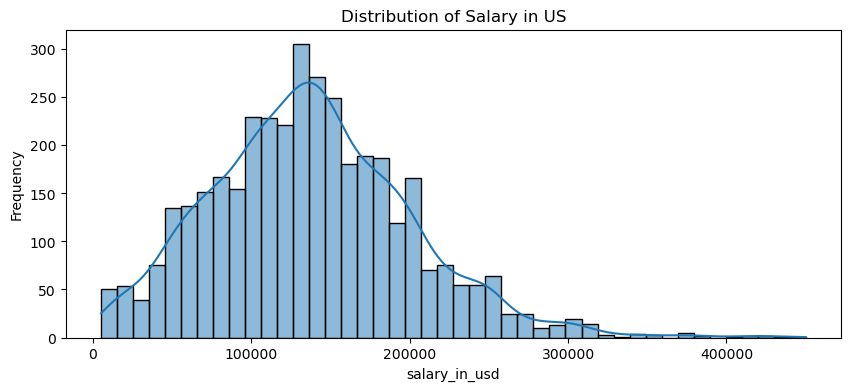

In [38]:
plt.figure(figsize=(10, 4))
sns.histplot(df['salary_in_usd'], kde=True)
plt.xlabel('salary_in_usd')
plt.ylabel('Frequency')
plt.title('Distribution of Salary in US')
plt.show()

In [39]:
df['salary_in_usd'].describe()

count      3755.000000
mean     137570.389880
std       63055.625278
min        5132.000000
25%       95000.000000
50%      135000.000000
75%      175000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

numerical features

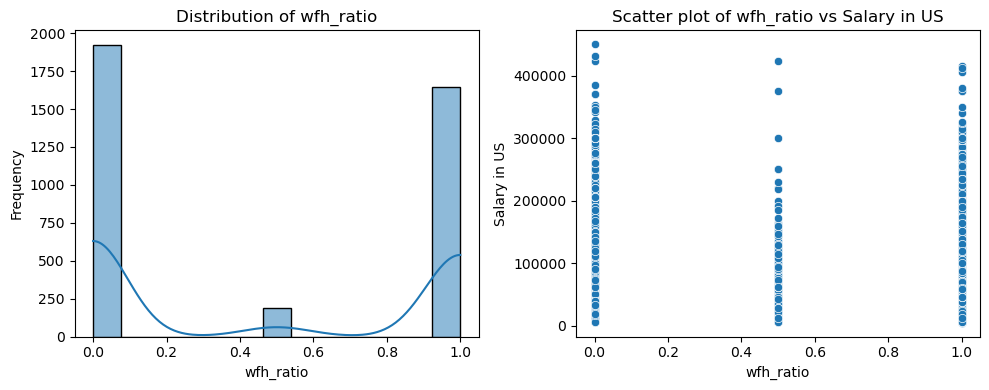

In [40]:
for column in num_col:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Left subplot - Distribution plot
    sns.histplot(df[column], kde=True, ax=axes[0])
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Distribution of {column}')
    
    # Right subplot - Scatter plot with 'salary in us'
    sns.scatterplot(data=df, x=column, y='salary_in_usd', ax=axes[1])
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Salary in US')
    axes[1].set_title(f'Scatter plot of {column} vs Salary in US')
    
    plt.tight_layout()
    plt.show()

categorical features

In [41]:
df[cat_col].describe()

,tenure,exp_entry,exp_mid,exp_senior,exp_expert,emptype_parttime,emptype_freelance,emptype_contract,emptype_fulltime,title_ds,...,comp_loc_developing,empyee_loc_developed,empyee_loc_emerging,empyee_loc_developing,work_aboard,work_aboard_higher,work_aboard_lower,comp_size_small,comp_size_mid,comp_size_large
count,3755.0,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,...,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000
mean,0.0,0.085220,0.214381,0.670040,0.030360,0.004527,0.002663,0.002663,0.990146,0.314514,...,0.037816,0.905726,0.040479,0.040213,0.025566,0.015712,0.000799,0.039414,0.839680,0.120905
std,0.0,0.279246,0.410447,0.470261,0.171597,0.067142,0.051543,0.051543,0.098788,0.464384,...,0.190777,0.292249,0.197107,0.196485,0.157857,0.124377,0.028258,0.194604,0.366951,0.326061
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


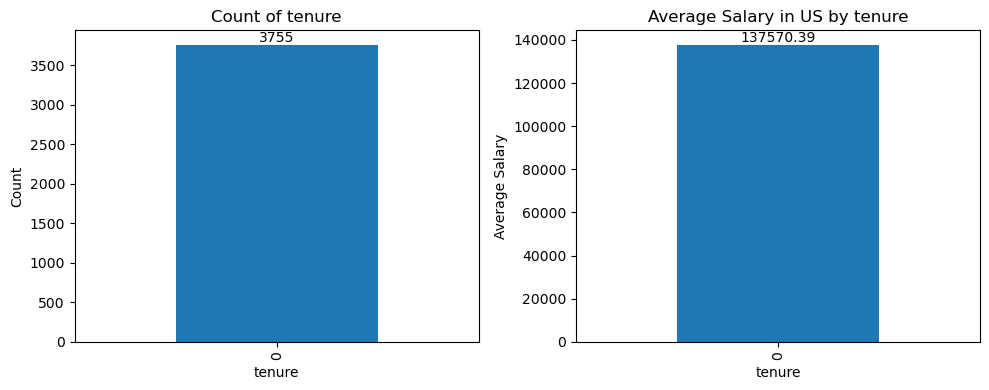

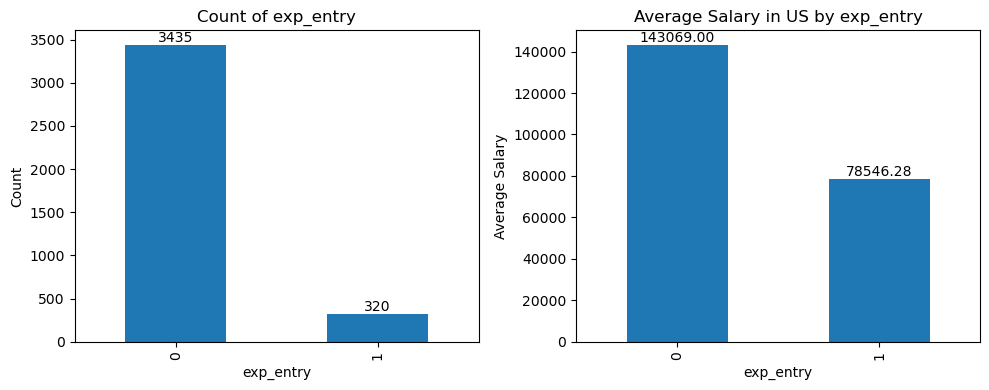

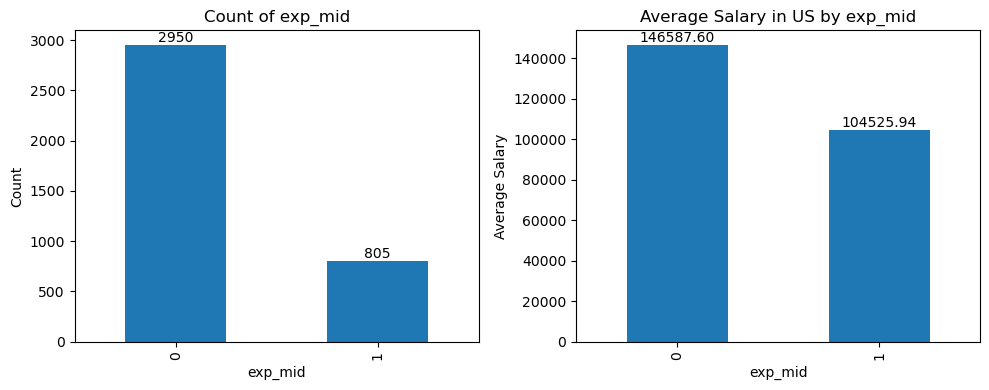

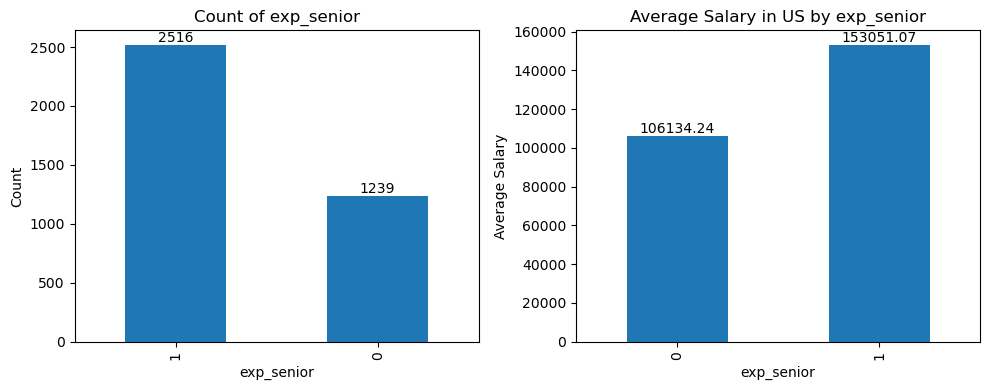

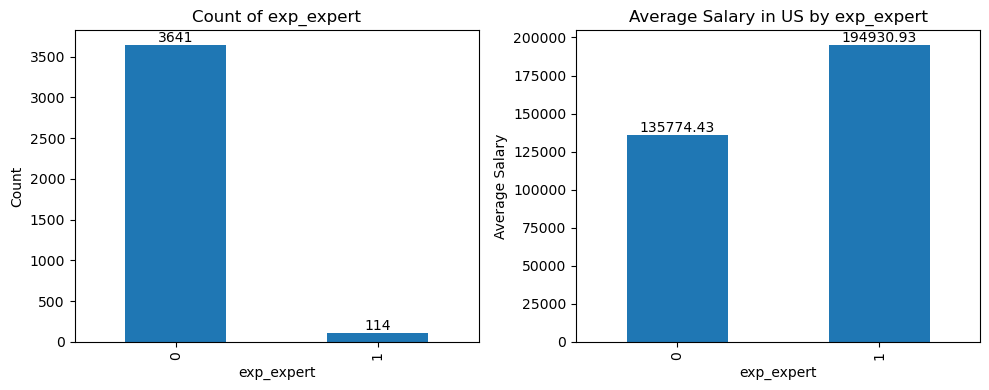

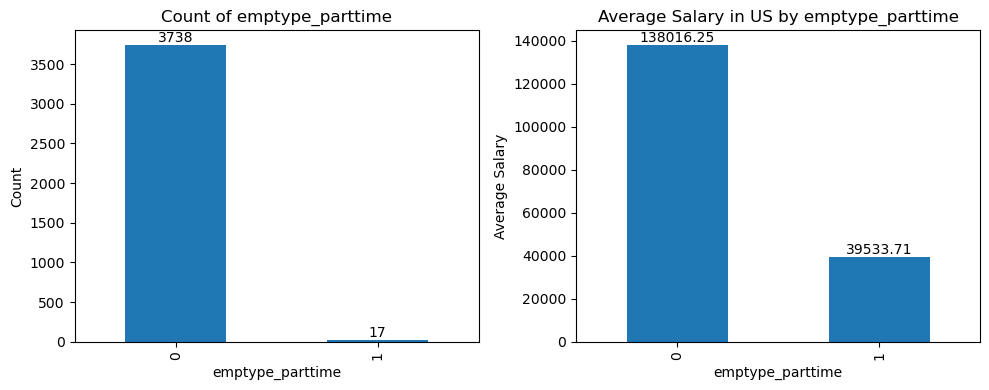

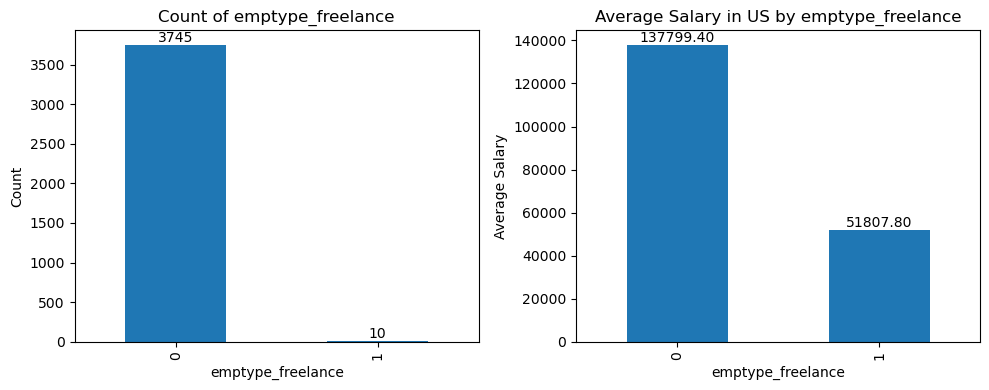

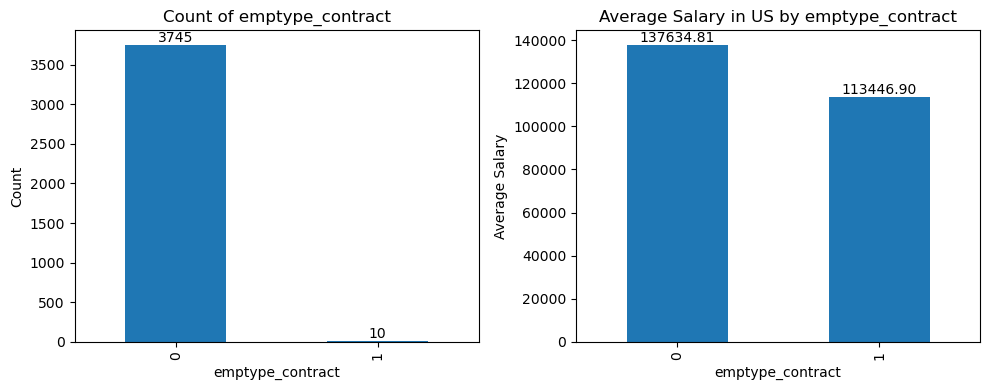

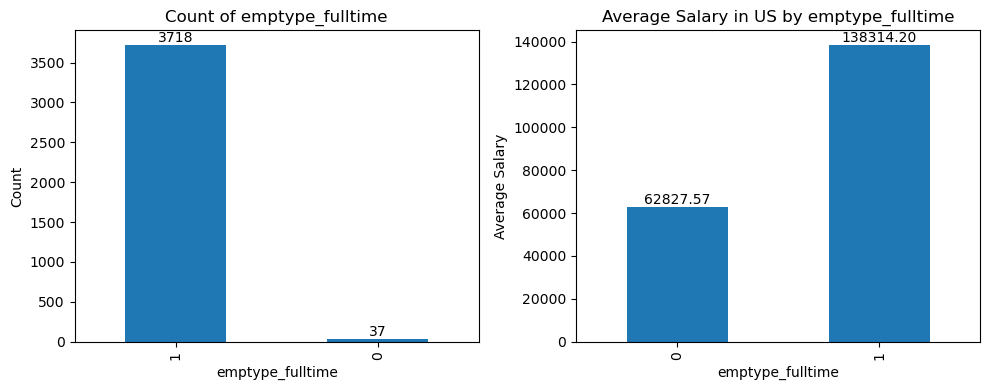

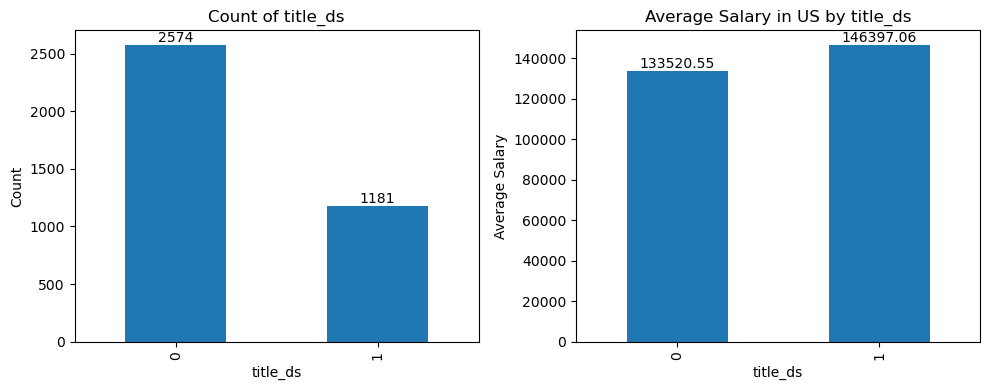

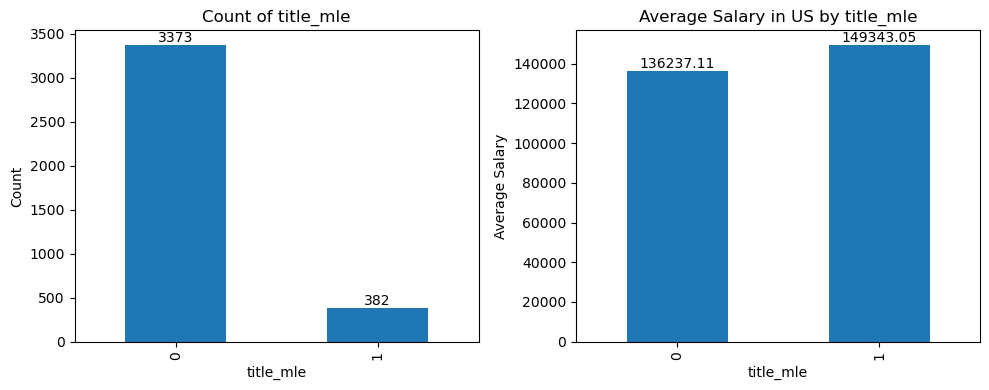

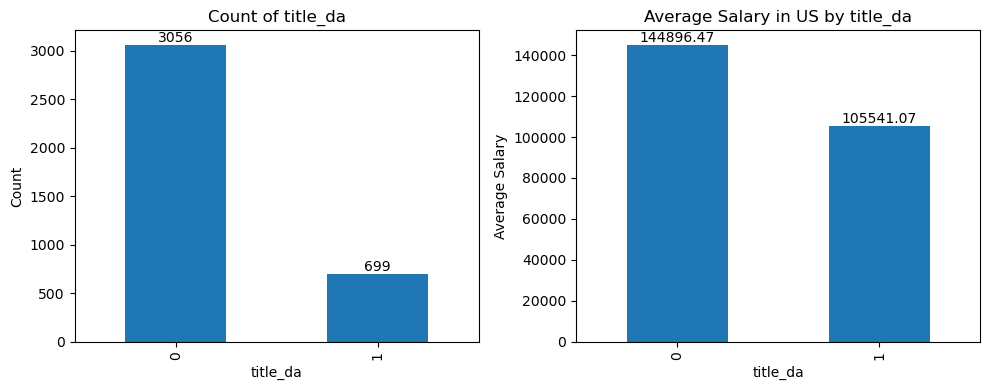

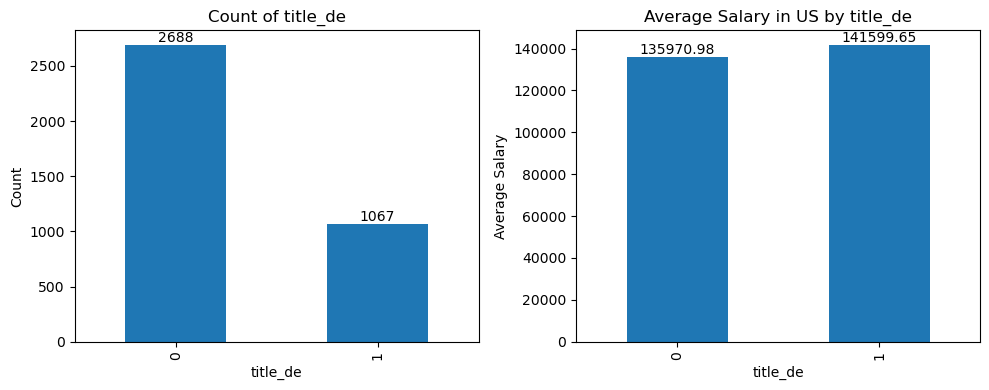

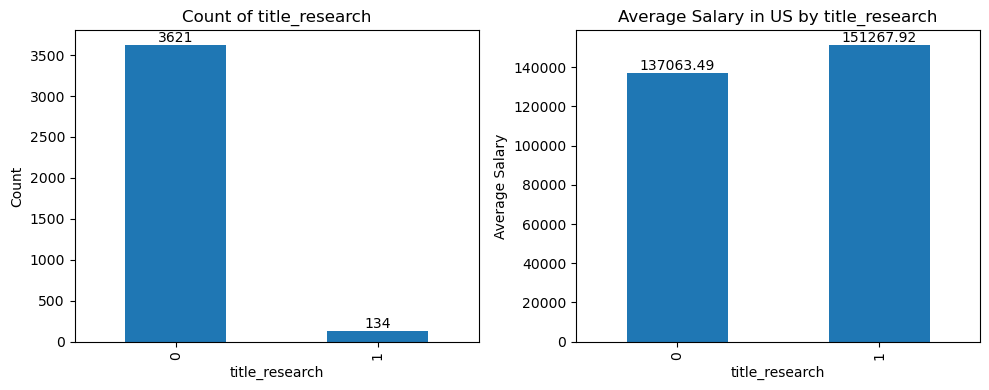

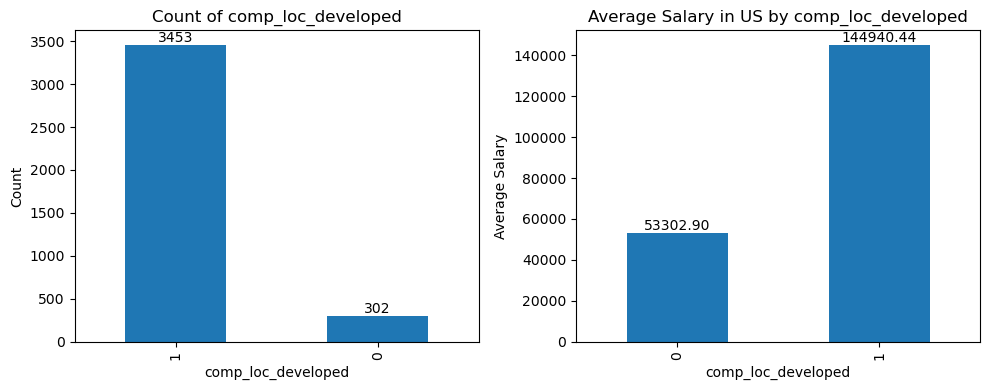

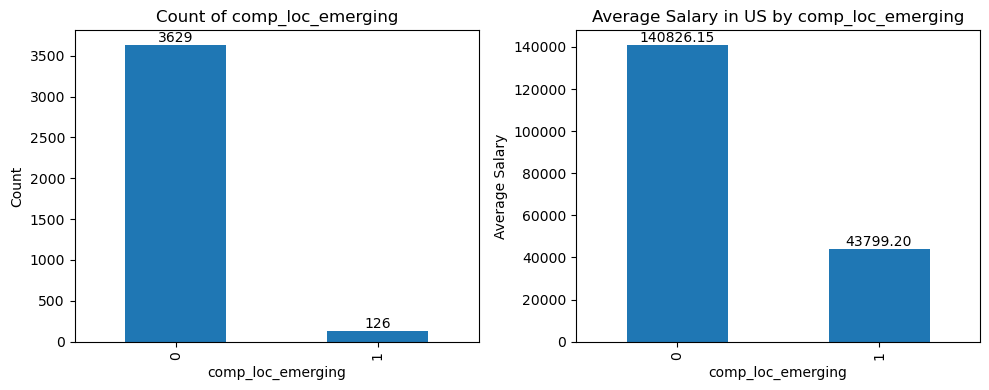

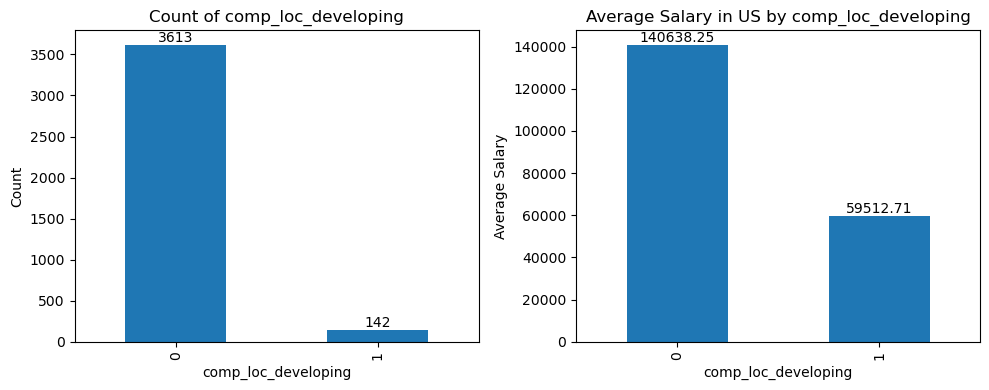

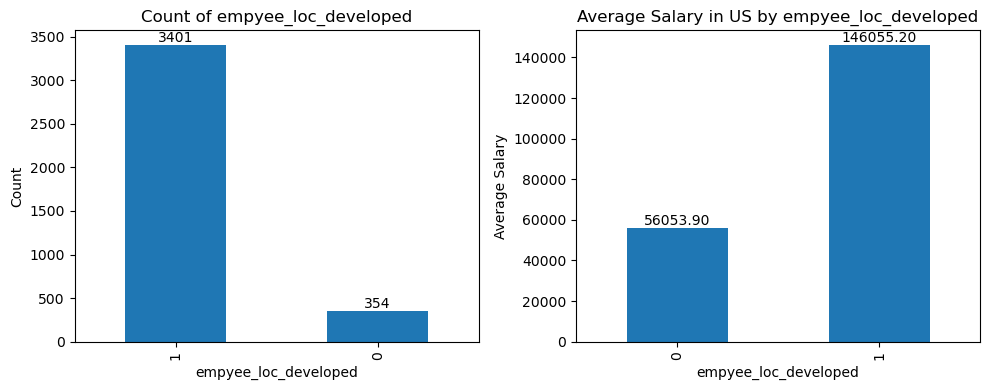

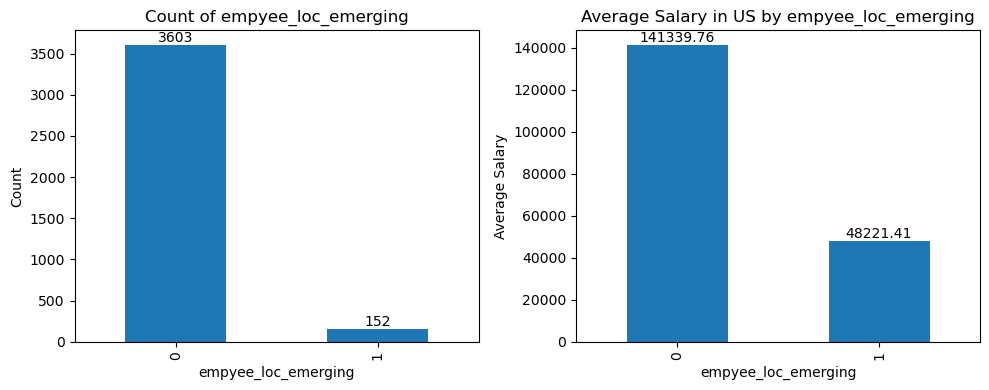

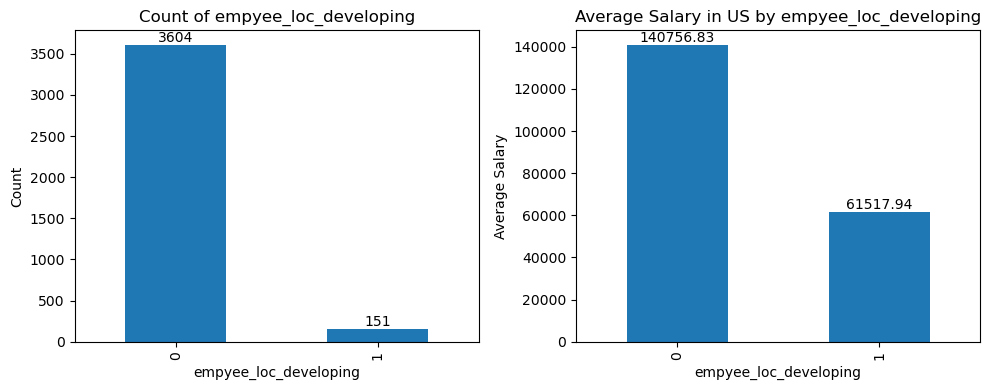

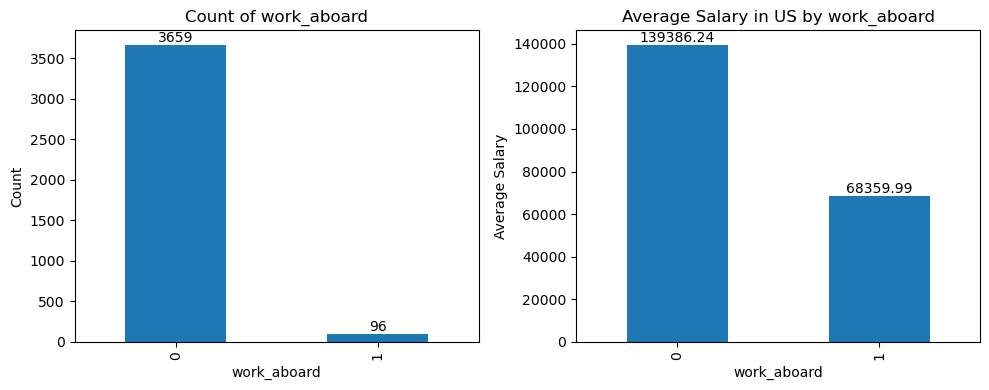

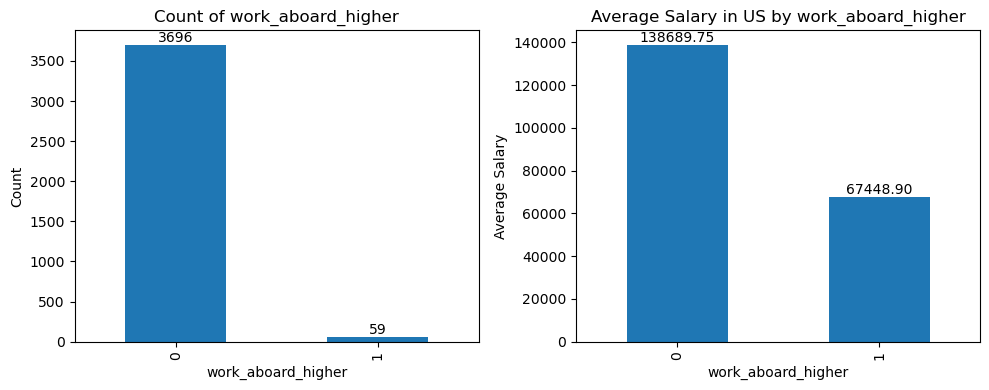

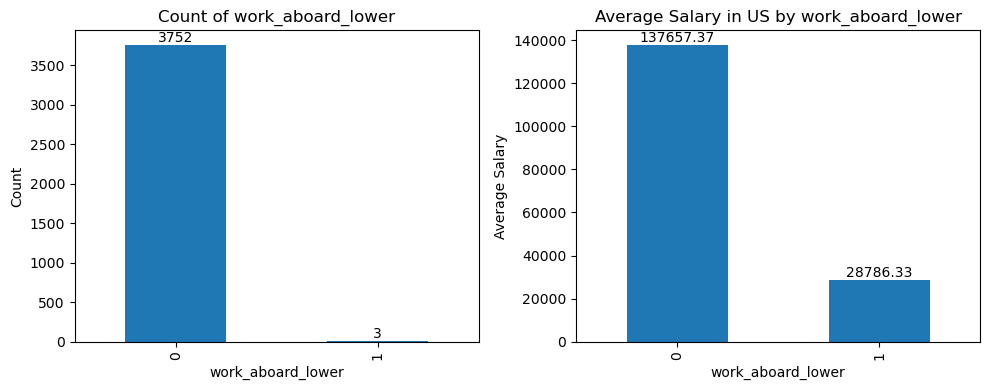

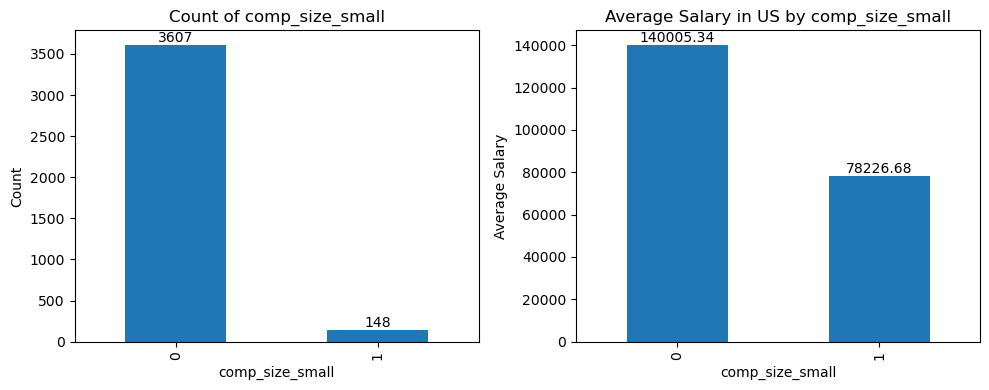

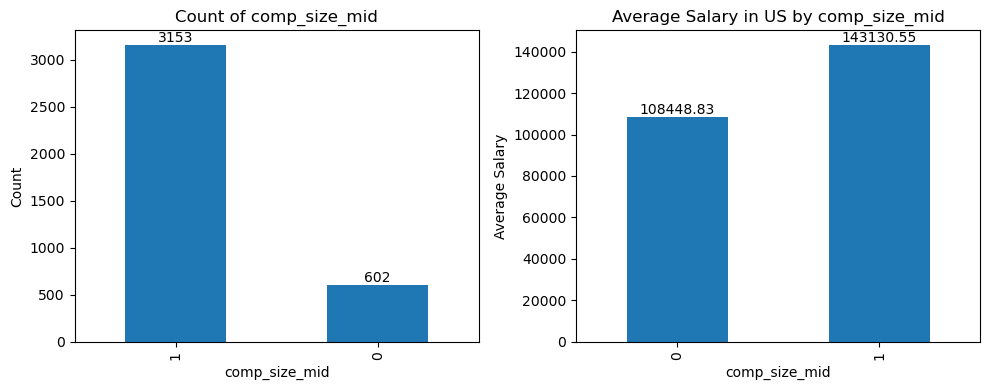

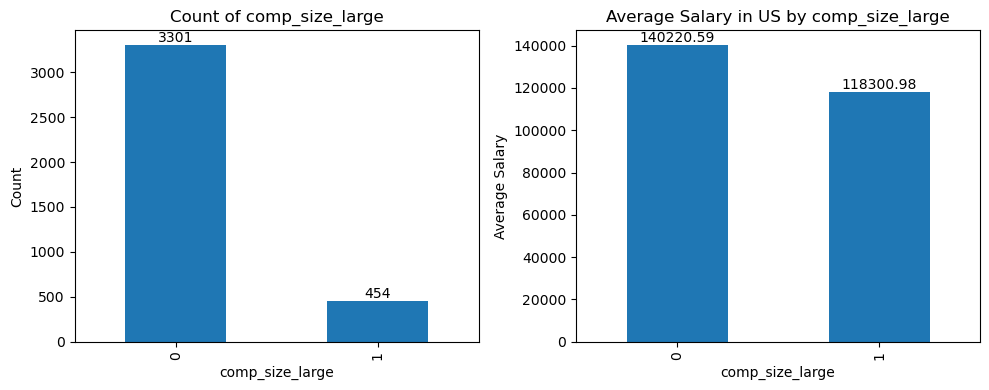

In [42]:
for column in cat_col:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Left subplot - Bar chart for counts
    category_counts = df[column].value_counts()
    total_count = len(df[column])
    ax = category_counts.plot(kind='bar', ax=axes[0])
    for i, count in enumerate(category_counts):
        ax.annotate(f'{count}', xy=(i, count), ha='center', va='bottom')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Count of {column}')
    
    # Right subplot - Bar chart for average salary
    avg_salary = df.groupby(column)['salary_in_usd'].mean()
    ax2 = avg_salary.plot(kind='bar', ax=axes[1])
    for i, avg in enumerate(avg_salary):
        ax2.annotate(f'{avg:.2f}', xy=(i, avg), ha='center', va='bottom')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Average Salary')
    axes[1].set_title(f'Average Salary in US by {column}')
    
    plt.tight_layout()
    plt.show()

correlation

In [43]:
corr = df.corr()

<Axes: >

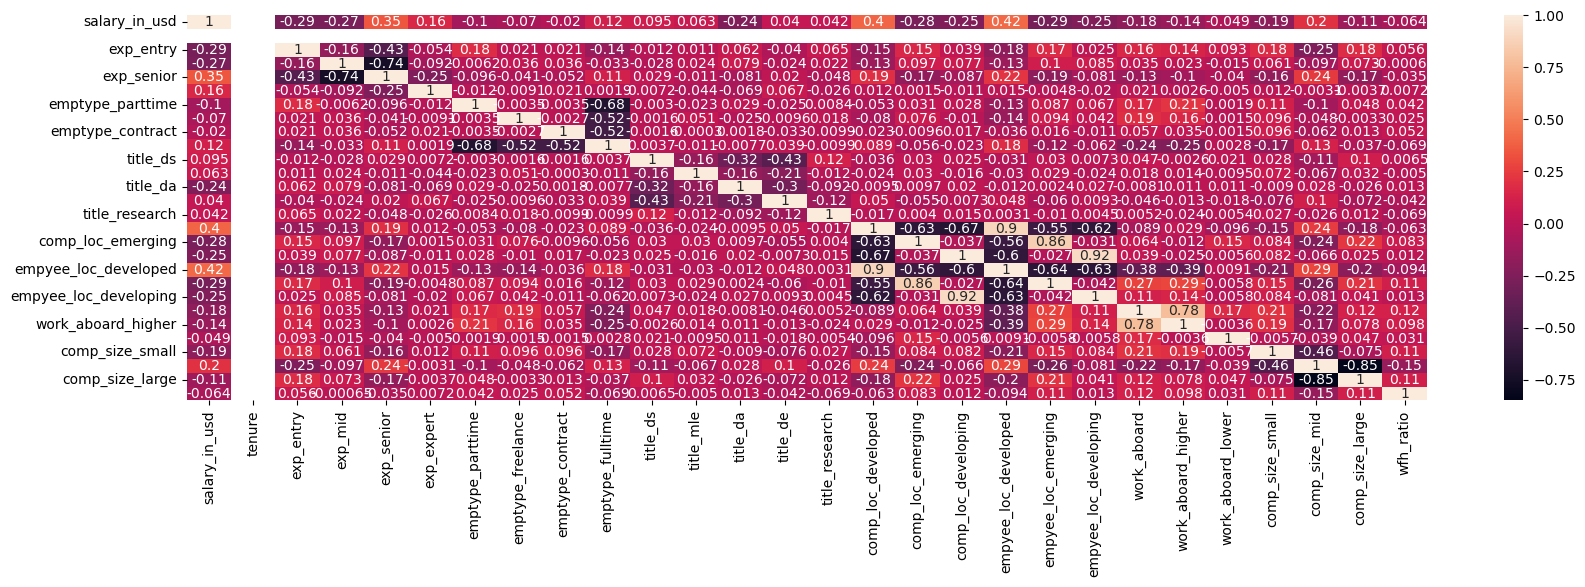

In [44]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, ax=ax)

In [45]:
corr_table = corr['salary_in_usd'].sort_values(ascending=False)

In [46]:
corr_table

salary_in_usd            1.000000
empyee_loc_developed     0.417136
comp_loc_developed       0.395275
exp_senior               0.349900
comp_size_mid            0.201830
exp_expert               0.160986
emptype_fulltime         0.118263
title_ds                 0.094831
title_mle                0.062839
title_research           0.041794
title_de                 0.040265
emptype_contract        -0.019772
work_aboard_lower       -0.048790
wfh_ratio               -0.064171
emptype_freelance       -0.070292
emptype_parttime        -0.104864
comp_size_large         -0.113346
work_aboard_higher      -0.140522
work_aboard             -0.177811
comp_size_small         -0.190663
title_da                -0.242965
comp_loc_developing     -0.245448
empyee_loc_developing   -0.246913
exp_mid                 -0.273791
comp_loc_emerging       -0.277137
exp_entry               -0.285743
empyee_loc_emerging     -0.291081
tenure                        NaN
Name: salary_in_usd, dtype: float64

In [47]:
corr_abs_table = corr['salary_in_usd'].abs().sort_values(ascending=False)

In [48]:
corr_abs_table

salary_in_usd            1.000000
empyee_loc_developed     0.417136
comp_loc_developed       0.395275
exp_senior               0.349900
empyee_loc_emerging      0.291081
exp_entry                0.285743
comp_loc_emerging        0.277137
exp_mid                  0.273791
empyee_loc_developing    0.246913
comp_loc_developing      0.245448
title_da                 0.242965
comp_size_mid            0.201830
comp_size_small          0.190663
work_aboard              0.177811
exp_expert               0.160986
work_aboard_higher       0.140522
emptype_fulltime         0.118263
comp_size_large          0.113346
emptype_parttime         0.104864
title_ds                 0.094831
emptype_freelance        0.070292
wfh_ratio                0.064171
title_mle                0.062839
work_aboard_lower        0.048790
title_research           0.041794
title_de                 0.040265
emptype_contract         0.019772
tenure                        NaN
Name: salary_in_usd, dtype: float64

# 5. Model

train/test split

In [49]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [50]:
X_train = train_df.drop(columns=['salary_in_usd'])
y_train = train_df['salary_in_usd']

X_test = test_df.drop(columns=['salary_in_usd'])
y_test = test_df['salary_in_usd']

In [51]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(3004, 27)
(3004,)
(751, 27)
(751,)


lgbm regression

In [52]:
model = lgb.LGBMRegressor()

In [53]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 22
[LightGBM] [Info] Start training from score 138055.989348


LGBMRegressor()

In [54]:
y_pred = model.predict(X_test)

# 6. Result

In [55]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [56]:
mse

2585430525.576347

In [57]:
rmse

50847.12898066465

In [58]:
mae

38668.49746757772

In [59]:
mape

38.4461146527418